In [1]:
# Librairies personnalisées
from my_functions.common_functions import *
from my_functions.machine_learning_common_functions import *
from my_functions.dimensionality_reduction_functions import *
from my_functions.BorutaLGBM import BorutaPyForLGB
from BorutaShap import BorutaShap

from sklearn.manifold import TSNE
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from flaml import AutoML
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from lightgbm import LGBMClassifier, early_stopping, Dataset, cv, plot_tree, plot_metric, plot_importance
from sklearn.metrics import roc_auc_score, make_scorer, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK
from sklearn.model_selection import StratifiedKFold
import shap

import gc
import re
import time
import dill

import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
offline.init_notebook_mode()

# import cufflinks and offline mode
import cufflinks as cf
cf.go_offline()

# # Supress unnecessary warnings so that presentation looks clean
# import warnings
# warnings.filterwarnings("ignore")

# 1. Chargement des Données

In [2]:
path_data = './Projet+Mise+en+prod+-+home-credit-default-risk/'

In [3]:
df = pd.read_csv(path_data+'data.csv')

In [4]:
if "SK_ID_CURR" in df.columns.tolist():
    df = df.drop(columns="SK_ID_CURR")

Le data set contient :
	- 307505 lignes et 530 colonnes.
	- 0 valeurs manquantes, ce qui représente 0.0 % du data set.


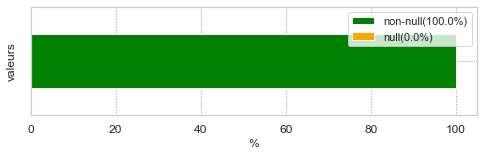

Voici un sous-échantillon aléatoire :


TARGET  GENDER  OWN_CAR  OWN_REALTY  AMT_ANNUITY  AMT_GOODS_PRICE  \
18655      0.0     1.0      0.0         0.0      23872.5         225000.0   
234805     0.0     0.0      0.0         1.0      32125.5         675000.0   
296720     0.0     1.0      0.0         1.0      22860.0         450000.0   
156924     1.0     1.0      0.0         1.0      26509.5         450000.0   
39413      0.0     0.0      1.0         0.0      38263.5         900000.0   
...        ...     ...      ...         ...          ...              ...   
273665     0.0     1.0      1.0         0.0      11812.5         112500.0   
273251     0.0     1.0      0.0         0.0      17446.5         360000.0   
62223      1.0     1.0      1.0         1.0      13500.0         270000.0   
142777     1.0     0.0      0.0         0.0      38686.5         675000.0   
26375      1.0     1.0      0.0         0.0       9000.0         180000.0   

        REGION_POPULATION_RELATIVE  DAYS_REGISTRATION  FLAG_MOBIL  \
18655                     0.024612            -5132.0         1.0   
234805                    0.010033            -1424.0         1.0   
296720                    0.020706            -5316.0         1.0   
156924                    0.018036             -992.0         1.0   
39413                     0.026398            -5444.0         1.0   
...                            ...                ...         ...   
273665                    0.015221            -2596.0         1.0   
273251                    0.001417            -8880.0         1.0   
62223                     0.010147            -1778.0         1.0   
142777                    0.009178            -5536.0         1.0   
26375                     0.028656            -3208.0         1.0   

        FLAG_EMP_PHONE  FLAG_WORK_PHONE  FLAG_CONT_MOBILE  FLAG_PHONE  \
18655              1.0              0.0               1.0         1.0   
234805             1.0              0.0               1.0         1.0   
296720             1.0              1.0               1.0         0.0   
156924             1.0              1.0               1.0         0.0   
39413              1.0              0.0               1.0         0.0   
...                ...              ...               ...         ...   
273665             0.0              0.0               1.0         1.0   
273251             1.0              0.0               1.0         1.0   
62223              1.0              0.0               1.0         0.0   
142777             1.0              0.0               1.0         1.0   
26375              1.0              0.0               1.0         0.0   

        FLAG_EMAIL  CNT_FAM_MEMBERS  REGION_RATING_CLIENT  \
18655          0.0              2.0                   2.0   
234805         0.0              1.0                   2.0   
296720         0.0              1.0                   3.0   
156924         0.0              2.0                   3.0   
39413          0.0              3.0                   2.0   
...            ...              ...                   ...   
273665         0.0              2.0                   2.0   
273251         1.0              1.0                   2.0   
62223          0.0              3.0                   2.0   
142777         0.0              3.0                   2.0   
26375          0.0              2.0                   2.0   

        HOUR_APPR_PROCESS_START  REG_REGION_NOT_LIVE_REGION  \
18655                      14.0                         0.0   
234805                      7.0                         0.0   
296720                     12.0                         0.0   
156924                      5.0                         0.0   
39413                      10.0                         0.0   
...                         ...                         ...   
273665                     12.0                         0.0   
273251                     14.0                         0.0   
62223                      13.0                         0.0   
142777        

In [5]:
verifier_taille(df)
afficher_echantillon(df, n=1000, frac=1.)

# 2. Features Selection : Boruta-SHAP

In [6]:
x_train, x_test, y_train, y_test = trainning_sets(df, 'TARGET')

In [6]:
lgbm_params = {
    'device_type':'gpu',
    'scale_pos_weight':(len(y_train)-sum(y_train))/sum(y_train),                            
    'random_state':0,
    'verbose':2,
    'n_jobs':-1,
    'n_estimators':100,
    'learning_rate':0.2,
    'max_depth':6,
    'num_leaves':30,
    'colsample_bytree':0.613,
    'subsample':0.708,
    'max_bin':63,
    'reg_alpha':3.564,
    'reg_lambda':4.930,
    'min_child_weight':6,
    'min_child_samples':165,   
}

model = LGBMClassifier(**lgbm_params)
selector = BorutaShap(model=model, importance_measure = 'shap', classification = True)
selector.fit(X = pd.DataFrame(x_train, columns=df.drop(columns='TARGET').columns), y = y_train, n_trials = 50, random_state=0, sample=False, normalize=False, verbose = True)
# n_trials -> number of iterations for Boruta algorithm
# sample -> samples the data so it goes faster

  0%|          | 0/50 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.895640
[LightGBM] [Info] Total Bins 59338
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 1389
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 806 dense feature groups (132.69 MB) transferred to GPU in 0.075680 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 

  2%|▏         | 1/50 [06:22<5:12:19, 382.45s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.894945
[LightGBM] [Info] Total Bins 59368
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 1389
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 804 dense feature groups (132.04 MB) transferred to GPU in 0.076109 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 

  4%|▍         | 2/50 [11:39<4:35:05, 343.86s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.895972
[LightGBM] [Info] Total Bins 59346
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 1389
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 806 dense feature groups (132.69 MB) transferred to GPU in 0.075629 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30

  6%|▌         | 3/50 [16:48<4:17:02, 328.13s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.894773
[LightGBM] [Info] Total Bins 59368
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 1388
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 804 dense feature groups (132.04 MB) transferred to GPU in 0.069856 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 

  8%|▊         | 4/50 [21:23<3:55:28, 307.14s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.895419
[LightGBM] [Info] Total Bins 59417
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 1388
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 806 dense feature groups (132.69 MB) transferred to GPU in 0.076030 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 

 10%|█         | 5/50 [26:21<3:47:45, 303.67s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.895132
[LightGBM] [Info] Total Bins 59395
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 1388
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 805 dense feature groups (132.69 MB) transferred to GPU in 0.077779 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 

 12%|█▏        | 6/50 [31:13<3:39:51, 299.81s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.895953
[LightGBM] [Info] Total Bins 59362
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 1389
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 806 dense feature groups (132.69 MB) transferred to GPU in 0.067367 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30

 14%|█▍        | 7/50 [36:00<3:31:57, 295.76s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.895442
[LightGBM] [Info] Total Bins 59388
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 1388
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 806 dense feature groups (132.69 MB) transferred to GPU in 0.078315 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 

 16%|█▌        | 8/50 [40:43<3:24:01, 291.45s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.895296
[LightGBM] [Info] Total Bins 59431
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 1389
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 805 dense feature groups (132.69 MB) transferred to GPU in 0.076155 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 

 18%|█▊        | 9/50 [44:45<3:08:43, 276.19s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.895294
[LightGBM] [Info] Total Bins 59368
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 1389
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 805 dense feature groups (132.69 MB) transferred to GPU in 0.070846 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 

 20%|██        | 10/50 [48:52<2:57:57, 266.95s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.896621
[LightGBM] [Info] Total Bins 59376
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 1389
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 808 dense feature groups (132.69 MB) transferred to GPU in 0.076365 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30

 22%|██▏       | 11/50 [52:51<2:48:04, 258.58s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.896283
[LightGBM] [Info] Total Bins 59367
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 1389
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 807 dense feature groups (132.69 MB) transferred to GPU in 0.074720 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30

 24%|██▍       | 12/50 [56:59<2:41:43, 255.37s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.894952
[LightGBM] [Info] Total Bins 59344
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 1389
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 804 dense feature groups (132.04 MB) transferred to GPU in 0.069454 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 

 26%|██▌       | 13/50 [1:01:31<2:40:29, 260.27s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.895299
[LightGBM] [Info] Total Bins 59416
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 1389
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 805 dense feature groups (132.69 MB) transferred to GPU in 0.075267 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 

 28%|██▊       | 14/50 [1:05:38<2:33:43, 256.22s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.771438
[LightGBM] [Info] Total Bins 10671
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 198
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 176 dense feature groups (28.90 MB) transferred to GPU in 0.025072 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 an

 30%|███       | 15/50 [1:09:51<2:29:01, 255.47s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.775578
[LightGBM] [Info] Total Bins 9548
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 178
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 157 dense feature groups (26.28 MB) transferred to GPU in 0.020188 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 32%|███▏      | 16/50 [1:11:00<1:52:52, 199.18s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.771375
[LightGBM] [Info] Total Bins 9526
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 178
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 156 dense feature groups (25.62 MB) transferred to GPU in 0.020672 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 34%|███▍      | 17/50 [1:12:07<1:27:48, 159.64s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.775481
[LightGBM] [Info] Total Bins 9549
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 178
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 157 dense feature groups (26.28 MB) transferred to GPU in 0.021485 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 36%|███▌      | 18/50 [1:13:13<1:10:07, 131.49s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.771411
[LightGBM] [Info] Total Bins 9549
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 178
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 156 dense feature groups (25.62 MB) transferred to GPU in 0.023223 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 38%|███▊      | 19/50 [1:14:18<57:32, 111.38s/it]  

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.771147
[LightGBM] [Info] Total Bins 9031
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 170
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 148 dense feature groups (24.31 MB) transferred to GPU in 0.020461 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 40%|████      | 20/50 [1:15:24<48:49, 97.65s/it] 

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.771180
[LightGBM] [Info] Total Bins 9040
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 170
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 148 dense feature groups (24.31 MB) transferred to GPU in 0.021386 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 42%|████▏     | 21/50 [1:16:29<42:30, 87.94s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.771246
[LightGBM] [Info] Total Bins 9042
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 170
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 148 dense feature groups (24.31 MB) transferred to GPU in 0.020665 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 44%|████▍     | 22/50 [1:17:35<37:57, 81.36s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.775467
[LightGBM] [Info] Total Bins 9040
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 170
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 149 dense feature groups (24.96 MB) transferred to GPU in 0.023331 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 46%|████▌     | 23/50 [1:18:45<35:08, 78.08s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.775520
[LightGBM] [Info] Total Bins 9024
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 170
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 149 dense feature groups (24.96 MB) transferred to GPU in 0.021420 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 48%|████▊     | 24/50 [1:19:53<32:29, 74.98s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.771398
[LightGBM] [Info] Total Bins 9042
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 170
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 148 dense feature groups (24.31 MB) transferred to GPU in 0.026510 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 50%|█████     | 25/50 [1:21:00<30:16, 72.65s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.771382
[LightGBM] [Info] Total Bins 9042
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 170
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 148 dense feature groups (24.31 MB) transferred to GPU in 0.019627 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 52%|█████▏    | 26/50 [1:22:07<28:20, 70.83s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.775454
[LightGBM] [Info] Total Bins 9021
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 170
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 149 dense feature groups (24.96 MB) transferred to GPU in 0.021025 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 54%|█████▍    | 27/50 [1:23:13<26:35, 69.36s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.771216
[LightGBM] [Info] Total Bins 9039
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 170
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 148 dense feature groups (24.31 MB) transferred to GPU in 0.026050 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 56%|█████▌    | 28/50 [1:24:19<25:04, 68.38s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.771252
[LightGBM] [Info] Total Bins 9040
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 170
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 148 dense feature groups (24.31 MB) transferred to GPU in 0.021166 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 58%|█████▊    | 29/50 [1:25:29<24:05, 68.84s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.771329
[LightGBM] [Info] Total Bins 9043
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 170
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 148 dense feature groups (24.31 MB) transferred to GPU in 0.022645 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 60%|██████    | 30/50 [1:26:35<22:38, 67.92s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.775569
[LightGBM] [Info] Total Bins 9041
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 170
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 149 dense feature groups (24.96 MB) transferred to GPU in 0.018901 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 62%|██████▏   | 31/50 [1:27:41<21:24, 67.58s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.784186
[LightGBM] [Info] Total Bins 8913
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 168
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 149 dense feature groups (24.96 MB) transferred to GPU in 0.025513 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 64%|██████▍   | 32/50 [1:28:54<20:44, 69.16s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.784264
[LightGBM] [Info] Total Bins 8914
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 168
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 149 dense feature groups (24.96 MB) transferred to GPU in 0.025184 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 66%|██████▌   | 33/50 [1:29:59<19:15, 67.97s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.779103
[LightGBM] [Info] Total Bins 8902
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 168
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 148 dense feature groups (24.31 MB) transferred to GPU in 0.020791 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 68%|██████▊   | 34/50 [1:31:07<18:04, 67.76s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.784148
[LightGBM] [Info] Total Bins 8901
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 168
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 149 dense feature groups (24.96 MB) transferred to GPU in 0.020612 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 70%|███████   | 35/50 [1:32:13<16:47, 67.19s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.784115
[LightGBM] [Info] Total Bins 8902
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 168
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 149 dense feature groups (24.96 MB) transferred to GPU in 0.022668 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 72%|███████▏  | 36/50 [1:33:18<15:34, 66.75s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.778815
[LightGBM] [Info] Total Bins 8904
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 168
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 148 dense feature groups (24.31 MB) transferred to GPU in 0.020288 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 74%|███████▍  | 37/50 [1:34:23<14:21, 66.26s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.784373
[LightGBM] [Info] Total Bins 8796
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 166
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 147 dense feature groups (24.31 MB) transferred to GPU in 0.022934 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 76%|███████▌  | 38/50 [1:35:28<13:09, 65.77s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.778963
[LightGBM] [Info] Total Bins 8797
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 166
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 146 dense feature groups (24.31 MB) transferred to GPU in 0.029176 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 78%|███████▊  | 39/50 [1:36:34<12:04, 65.83s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.779086
[LightGBM] [Info] Total Bins 8799
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 166
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 146 dense feature groups (24.31 MB) transferred to GPU in 0.021861 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 80%|████████  | 40/50 [1:37:39<10:56, 65.67s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.784271
[LightGBM] [Info] Total Bins 8815
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 166
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 147 dense feature groups (24.31 MB) transferred to GPU in 0.020349 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 82%|████████▏ | 41/50 [1:38:50<10:03, 67.11s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.784229
[LightGBM] [Info] Total Bins 8815
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 166
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 147 dense feature groups (24.31 MB) transferred to GPU in 0.020858 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 84%|████████▍ | 42/50 [1:39:55<08:53, 66.65s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.779016
[LightGBM] [Info] Total Bins 8799
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 166
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 146 dense feature groups (24.31 MB) transferred to GPU in 0.021019 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 86%|████████▌ | 43/50 [1:41:06<07:54, 67.79s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.784212
[LightGBM] [Info] Total Bins 8815
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 166
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 147 dense feature groups (24.31 MB) transferred to GPU in 0.021705 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 88%|████████▊ | 44/50 [1:42:14<06:48, 68.02s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.778873
[LightGBM] [Info] Total Bins 8796
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 166
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 146 dense feature groups (24.31 MB) transferred to GPU in 0.020047 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 90%|█████████ | 45/50 [1:43:20<05:35, 67.20s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.778912
[LightGBM] [Info] Total Bins 8810
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 166
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 146 dense feature groups (24.31 MB) transferred to GPU in 0.020639 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 92%|█████████▏| 46/50 [1:44:24<04:25, 66.29s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.784126
[LightGBM] [Info] Total Bins 8813
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 166
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 147 dense feature groups (24.31 MB) transferred to GPU in 0.019838 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 94%|█████████▍| 47/50 [1:45:28<03:17, 65.72s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.778990
[LightGBM] [Info] Total Bins 8811
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 166
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 146 dense feature groups (24.31 MB) transferred to GPU in 0.021234 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 96%|█████████▌| 48/50 [1:46:33<02:10, 65.42s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.784112
[LightGBM] [Info] Total Bins 8814
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 166
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 147 dense feature groups (24.31 MB) transferred to GPU in 0.022283 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

 98%|█████████▊| 49/50 [1:47:32<01:03, 63.46s/it]

[LightGBM] [Info] Number of positive: 13824, number of negative: 158378
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.779033
[LightGBM] [Info] Total Bins 8790
[LightGBM] [Info] Number of data points in the train set: 172202, number of used features: 166
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 146 dense feature groups (24.31 MB) transferred to GPU in 0.020218 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080278 -> initscore=-2.438578
[LightGBM] [Info] Start training from score -2.438578
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[LightGBM] [Debug] Trained a tree with leaves = 30 and

100%|██████████| 50/50 [1:48:41<00:00, 130.44s/it]

58 attributes confirmed important: ['INS_D365DPD_SUM', 'INSTAL_DPD_7_MEAN', 'ACTIVE_AMT_CREDIT_SUM_SUM', 'AMT_GOODS_PRICE', 'BURO_AMT_CREDIT_MAX_OVERDUE_MAX', 'INSTAL_SIGNIFICANT_LATE_PAYMENT_SUM', 'AMT_CREDIT', 'INS_D365INS_IS_DPD_UNDER_120_MEAN', 'INS_D365DPD_DIFF_MAX', 'GENDER', 'PREV_YIELD_GROUP_low_action_MEAN', 'OWN_CAR', 'NEW_DOC_KURT', 'PREV_APP_CREDIT_PERC_MIN', 'ACTIVE_BUREAU_CREDIT_DEBT_RATIO_MEAN', 'INSTAL_AMT_INSTALMENT_MIN', 'CREDIT_TO_GOODS_RATIO', 'AMT_ANNUITY', 'PREV_APP_CREDIT_PERC_MAX', 'INSTAL_INS_IS_DPD_UNDER_120_MEAN', 'PREV_CNT_PAYMENT_MEAN', 'DAYS_EMPLOYED', 'POS_REMAINING_INSTALMENTS', 'POS_MONTHS_BALANCE_MAX', 'APPROVED_AMT_DOWN_PAYMENT_MAX', 'DAYS_BIRTH', 'EXT_SOURCE_1', 'ACTIVE_DEBT_CREDIT_DIFF_MIN', 'INSTAL_AMT_PAYMENT_SUM', 'CREDIT_TO_GOODS_RATIO_2', 'ACTIVE_BUREAU_CREDIT_DEBT_RATIO_MAX', 'PAYMENT_RATE', 'EXT_SOURCES_MEAN', 'DAYS_ID_PUBLISH', 'REGION_RATING_CLIENT_W_CITY', 'EXT_SOURCE_3', 'INSTAL_DAYS_ENTRY_PAYMENT_MIN', 'BURO_ENDDATE_DIF_MAX', 'PREV_APP_C

In [7]:
# Display features to be removed
features_to_remove = selector.features_to_remove
print(features_to_remove)

['OWN_REALTY' 'CNT_CHILDREN' 'AMT_INCOME_TOTAL' 'FLAG_MOBIL'
 'FLAG_EMP_PHONE' 'FLAG_WORK_PHONE' 'FLAG_CONT_MOBILE' 'FLAG_PHONE'
 'FLAG_EMAIL' 'CNT_FAM_MEMBERS' 'REGION_RATING_CLIENT'
 'HOUR_APPR_PROCESS_START' 'REG_REGION_NOT_LIVE_REGION'
 'REG_REGION_NOT_WORK_REGION' 'LIVE_REGION_NOT_WORK_REGION'
 'REG_CITY_NOT_LIVE_CITY' 'REG_CITY_NOT_WORK_CITY'
 'LIVE_CITY_NOT_WORK_CITY' 'OBS_30_CNT_SOCIAL_CIRCLE'
 'OBS_60_CNT_SOCIAL_CIRCLE' 'DEF_60_CNT_SOCIAL_CIRCLE'
 'DAYS_LAST_PHONE_CHANGE' 'FLAG_DOCUMENT_2' 'FLAG_DOCUMENT_4'
 'FLAG_DOCUMENT_5' 'FLAG_DOCUMENT_6' 'FLAG_DOCUMENT_7' 'FLAG_DOCUMENT_8'
 'FLAG_DOCUMENT_9' 'FLAG_DOCUMENT_10' 'FLAG_DOCUMENT_11'
 'FLAG_DOCUMENT_12' 'FLAG_DOCUMENT_13' 'FLAG_DOCUMENT_14'
 'FLAG_DOCUMENT_15' 'FLAG_DOCUMENT_16' 'FLAG_DOCUMENT_17'
 'FLAG_DOCUMENT_18' 'FLAG_DOCUMENT_19' 'FLAG_DOCUMENT_20'
 'FLAG_DOCUMENT_21' 'AMT_REQ_CREDIT_BUREAU_HOUR'
 'AMT_REQ_CREDIT_BUREAU_DAY' 'AMT_REQ_CREDIT_BUREAU_WEEK'
 'AMT_REQ_CREDIT_BUREAU_MON' 'AMT_REQ_CREDIT_BUREAU_YEAR'
 'CONTRAC

In [8]:
dfbs = df.drop(columns=features_to_remove)
dfbs.to_csv(path_data+'data-boruta-shap.csv', index=False)
df = dfbs

# 3. Entrainement du Modèle

In [6]:
x_train, x_test, y_train, y_test = trainning_sets(df, 'TARGET')

In [7]:
# Fonction daffichage de l'évaluation du modèle
def EvalDisplay(clf, metric):
    y_predict = clf.predict(x_test)
    print('Socre:', metric(y_test, y_predict))
    
    #ROC
    AUC(y_train, clf.predict(x_train))
    AUC(y_test, y_predict)

    # Confusion Matrix        
    cm = confusion_matrix(y_test, y_predict, labels=clf.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot()
    plt.show()
    print(cm)

# Métrique d'évaluation du modèle : AUC
def MyScore(y_test, y_pred):
  return roc_auc_score(y_test, y_pred)

# Foncton de sauvegarde du modèle
def saveModel(model, model_name='model'):
    ### Create a Pickle file using serialization 
    with open('./pkl/'+model_name+".pkl",'wb') as io:
        dill.dump(model,io)

## 3.1. Avec Fonction de Coût Classique : AUC

### 3.1.1. Modèle Baseline : LogisticRegressionCV

In [8]:
def baseline(scoring):
    return LogisticRegressionCV(cv=10, scoring=make_scorer(scoring), random_state=0, n_jobs=-1).fit(x_train, y_train)

Socre: 0.5002170973665808


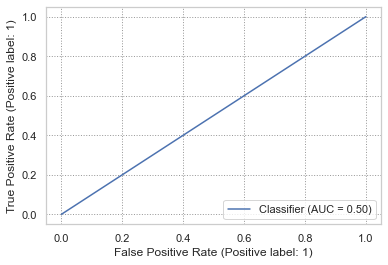

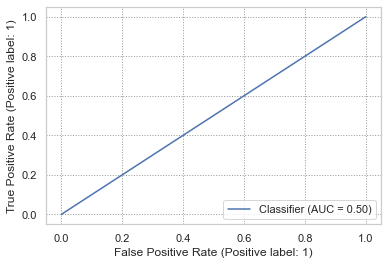

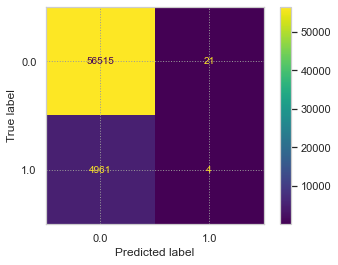

[[56515    21]
 [ 4961     4]]


In [9]:
clf = baseline(MyScore)
EvalDisplay(clf, MyScore)
saveModel(clf, 'baseline_auc')

### 3.1.2. Modèle Classique : LGBM

In [10]:
# Métrique d'évaluation adaptée à LGBM
def lgbm_metric(y, preds):   
    # # eval_name, eval_result, is_higher_better
    return 'auc', MyScore(y, preds), True

In [11]:
lgbm_params = {
    'device_type':'gpu',
    'scale_pos_weight':(len(y_train)-sum(y_train))/sum(y_train),                            
    'random_state':0,
    'verbose':2,
    'n_jobs':-1,
    'n_estimators':5000,
    'learning_rate':0.01,
    'max_depth':11,
    'num_leaves':58,
    'colsample_bytree':0.613,
    'subsample':0.708,
    'max_bin':63,
    'reg_alpha':3.564,
    'reg_lambda':4.930,
    'min_child_weight':6,
    'min_child_samples':165,   
}

def trainLGBM(params, metric, name):
    model = LGBMClassifier(**params)
    model = model.fit(x_train, y_train, eval_set=[(x_test, y_test)], eval_metric=metric)    
    print(model.best_score_)
    
    EvalDisplay(model, MyScore)
    saveModel(model, name)

    return model

def trainLGBM_CV(params, metric, name):
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
  X = x_train.values
  y = y_train

  best_score = 0
  best_model = None
  for train_index, test_index in skf.split(X, y):
    X_train_skf, X_test_skf = X[train_index], X[test_index]
    y_train_skf, y_test_skf = y[train_index], y[test_index]

    X_res, y_res = SMOTETomek(sampling_strategy=0.7, smote=SMOTE(k_neighbors=20, n_jobs=-1), random_state=0, n_jobs=-1).fit_resample(X_train_skf, y_train_skf)
    X_val, y_val = X_test_skf, y_test_skf

    model = LGBMClassifier(**params)
    try:
      model.fit(X_res, y_res, eval_set=[(X_val, y_val)], eval_metric=metric,  callbacks=[early_stopping(stopping_rounds=5, min_delta=0.001)])

      y_pred = model.predict(x_test)
      score = MyScore(y_test, y_pred)

      if score > best_score:
        best_score = score
        best_model = model
    except:
      pass

  EvalDisplay(best_model, MyScore)
  saveModel(best_model, name)

  return best_model

[LightGBM] [Info] Number of positive: 19860, number of negative: 226144
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.860232
[LightGBM] [Info] Total Bins 18359
[LightGBM] [Info] Number of data points in the train set: 246004, number of used features: 504
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 223 dense feature groups (52.55 MB) transferred to GPU in 0.036695 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432464
[LightGBM] [Info] Start training from score -2.432464
[LightGBM] [Debug] Trained a tree with leaves = 58 and depth = 9
[1]	valid_0's binary_logloss: 0.279013	valid_0's auc: 0.73043
[LightGBM] [Debug] Trained a tree with leaves = 58 and d

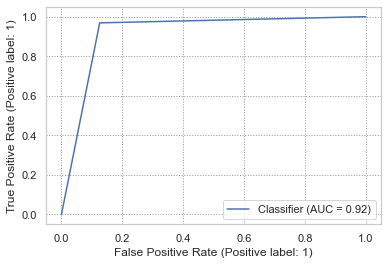

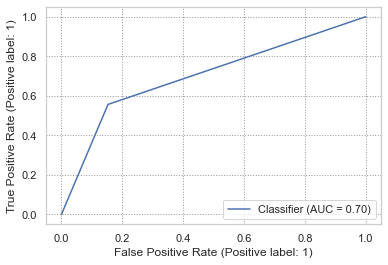

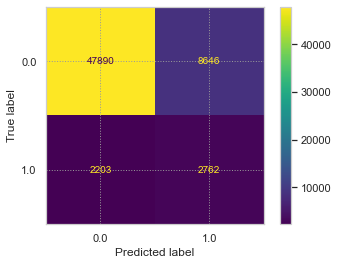

[[47890  8646]
 [ 2203  2762]]


In [12]:
lgbm = trainLGBM(lgbm_params, lgbm_metric, 'lgbm')

#### LGBM Light

In [13]:
lgbm_params2 = dict(lgbm_params)
lgbm_params2['n_estimators']=100
lgbm_params2['learning_rate']=0.2
lgbm_params2['max_depth']=6
lgbm_params2['num_leaves']=30

[LightGBM] [Info] Number of positive: 19860, number of negative: 226144
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.860232
[LightGBM] [Info] Total Bins 18359
[LightGBM] [Info] Number of data points in the train set: 246004, number of used features: 504
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 223 dense feature groups (52.55 MB) transferred to GPU in 0.044729 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432464
[LightGBM] [Info] Start training from score -2.432464
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[1]	valid_0's binary_logloss: 0.313066	valid_0's auc: 0.725901
[LightGBM] [Debug] Trained a tree with leaves = 30 and 

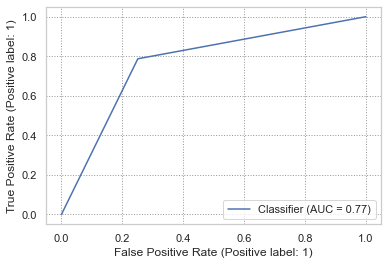

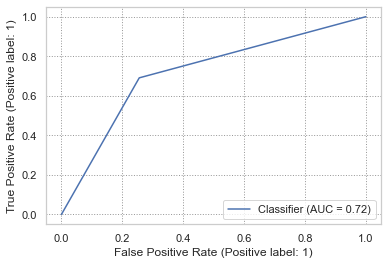

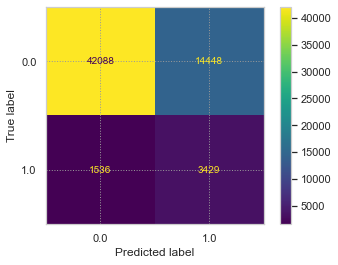

[[42088 14448]
 [ 1536  3429]]


In [14]:
lgbml = trainLGBM(lgbm_params2, lgbm_metric, 'lgbml')

[LightGBM] [Info] Number of positive: 179511, number of negative: 179511
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.878853
[LightGBM] [Info] Total Bins 31878
[LightGBM] [Info] Number of data points in the train set: 359022, number of used features: 510
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 236 dense feature groups (80.80 MB) transferred to GPU in 0.056906 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
Training until validation scores don't improve for 5 rounds
Using 0.001 as min_delta for all metrics.
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[Ligh

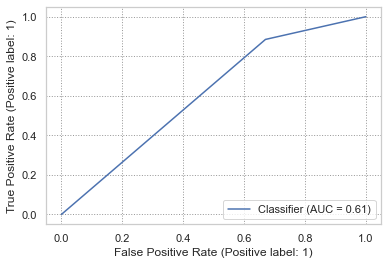

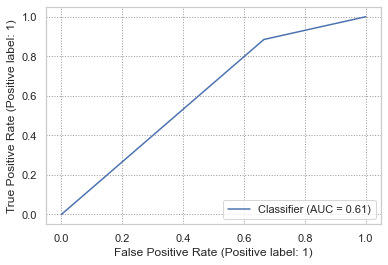

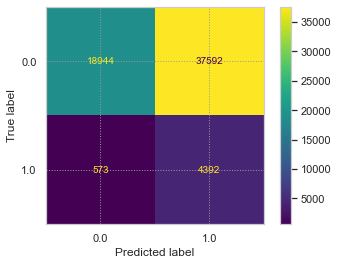

[[18944 37592]
 [  573  4392]]


In [15]:
lgbml_cv2 = trainLGBM_CV(lgbm_params2, lgbm_metric, 'lgbml_cv2')

In [16]:
0/0

ZeroDivisionError: division by zero

#### LGBM Flaml

In [ ]:
def flamlLGBM(time=60, metric='roc_auc', name='flamlgbm'):
    automl = AutoML()
    automl_settings = {
        "time_budget": time,  # in seconds
        "metric": metric,
        "task": 'classification',
        "estimator_list": ["lgbm"],
    }
    automl.fit(X_train=x_train, y_train=y_train, **automl_settings)
    print('Best hyperparmeter config:', automl.best_config)
    print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
    print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

    EvalDisplay(automl, roc_auc_score)
    saveModel(automl, name)

[flaml.automl: 09-03 04:29:18] {2565} INFO - task = classification
[flaml.automl: 09-03 04:29:18] {2567} INFO - Data split method: stratified
[flaml.automl: 09-03 04:29:18] {2570} INFO - Evaluation method: holdout
[flaml.automl: 09-03 04:29:29] {2689} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl: 09-03 04:29:29] {2831} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 09-03 04:29:29] {3133} INFO - iteration 0, current learner lgbm
[flaml.automl: 09-03 04:29:31] {3266} INFO - Estimated sufficient time budget=284392s. Estimated necessary time budget=284s.
[flaml.automl: 09-03 04:29:31] {3313} INFO -  at 12.7s,	estimator lgbm's best error=0.2855,	best estimator lgbm's best error=0.2855
[flaml.automl: 09-03 04:29:31] {3133} INFO - iteration 1, current learner lgbm
[flaml.automl: 09-03 04:29:32] {3313} INFO -  at 13.9s,	estimator lgbm's best error=0.2855,	best estimator lgbm's best error=0.2855
[flaml.automl: 09-03 04:29:32] {3133} INFO - iteration 2, current lear

Best hyperparmeter config: {'n_estimators': 4184, 'num_leaves': 22, 'min_child_samples': 16, 'learning_rate': 0.028795546493030708, 'log_max_bin': 10, 'colsample_bytree': 0.8021390579451955, 'reg_alpha': 0.0009765625, 'reg_lambda': 66.4693835780282, 'FLAML_sample_size': 221403}
Best accuracy on validation data: 0.7952
Training duration of best run: 630.1 s
Socre: 0.5134456620141756


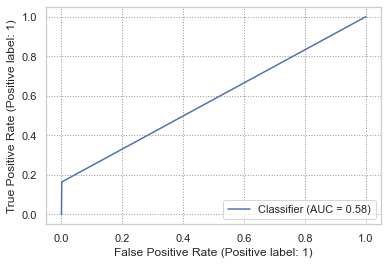

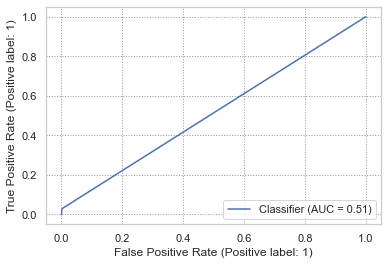

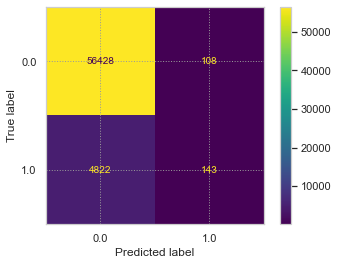

[[56428   108]
 [ 4822   143]]


In [ ]:
flamlLGBM(time=3600*2)

#### LGBM & HyperOPT

In [ ]:
best_params_bis = {}
best_score_bis = 0

# define the function we want to minimise
def MyModel(params):  

  model = LGBMClassifier(
                              device='gpu',random_state=0, verbose=-1, n_jobs=-1,
                              class_weight='balanced',
                              n_estimators=params['n_estimators'],
                              learning_rate=params['learning_rate'],
                              max_depth=params['max_depth'],
                              num_leaves=params['num_leaves'],
                              colsample_bytree =params['colsample_bytree '],
                              subsample=params['subsample'],
                              max_bin=params['max_bin'],
                              reg_alpha=params['reg_alpha'],
                              reg_lambda=params['reg_lambda'],
                              min_child_weight=params['min_child_weight'],
                              min_child_samples=params['min_child_samples']                             
                              ) 
  return model  

def objective(params):
  global best_params_bis
  global best_score_bis  

  skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
  X = x_train.values
  y = y_train

  best_score = 0
  scores = []
  for train_index, test_index in skf.split(X, y):
    X_train_skf, X_test_skf = X[train_index], X[test_index]
    y_train_skf, y_test_skf = y[train_index], y[test_index]

    X_res, y_res = SMOTETomek(sampling_strategy=params['sampling_strategy'], smote=SMOTE(k_neighbors=20, n_jobs=-1), random_state=0, n_jobs=-1).fit_resample(X_train_skf, y_train_skf)
    # X_val, y_val = SMOTETomek(sampling_strategy=params['sampling_strategy'], smote=SMOTE(k_neighbors=20, n_jobs=-1), random_state=0, n_jobs=-1).fit_resample(X_test_skf, y_test_skf)
    X_val, y_val = X_test_skf, y_test_skf

    model = MyModel(params)
    try:
      model.fit(X_res, y_res, eval_set=[(X_val, y_val)], eval_metric=lgbm_metric,  callbacks=[early_stopping(stopping_rounds=5, min_delta=0.001)])

      y_pred = model.predict(x_test)
      score = MyScore(y_test, y_pred)
      scores.append(score)

      if score > best_score:
        best_score = score
      if score > best_score_bis:
        best_score_bis = score
        best_params_bis = params
    except:
      pass
  return {'loss': -np.mean(scores), 'status': STATUS_OK}

search_space  = dict([
                    ('sampling_strategy', hp.uniform('sampling_strategy', 0.1, 1.)),
                    ('n_estimators', hp.choice('n_estimators', range(40, 200, 20))),
                    ('learning_rate', hp.uniform('learning_rate', 0.05, 0.3)),
                    ('max_depth', hp.choice('max_depth', range(4, 9, 2))),
                    ('num_leaves', hp.choice('num_leaves', range(5, 50, 5))),
                    ('max_bin', hp.choice('max_bin', range(50, 150, 10))),
                    ('reg_alpha', hp.loguniform('reg_alpha', 
                                                     np.log(0.1), np.log(10.))),
                    ('reg_lambda', hp.loguniform('reg_lambda', 
                                                     np.log(0.1), np.log(10.))),
                    ('min_child_weight', hp.loguniform('min_child_weight', 
                                                     np.log(0.001), np.log(10.))),
                    ('num_leaves', hp.choice('num_leaves', range(2, 100, 1))),
                    ('colsample_bytree ', hp.uniform('colsample_bytree ', 0.1, 1.0)),
                    ('subsample', hp.uniform('subsample', 0.1, 1.0)),
                    ('min_child_samples', hp.choice('min_child_samples', range(10, 1000, 10))),
                    ])
                    
# set the hyperparam tuning algorithm
algorithm=tpe.suggest

def hyperoptLGBM(max_evals=20, eval_metric=roc_auc_score, name='lgbmh'):
  best_params = fmin(
    fn=objective,
    space=search_space,
    algo=algorithm,
    max_evals=max_evals)

  print(best_params)
  
  lgbm = MyModel(best_params)

  X_res, y_res = SMOTETomek(sampling_strategy=best_params['sampling_strategy'], smote=SMOTE(k_neighbors=20, n_jobs=-1), random_state=0, n_jobs=-1).fit_resample(x_train, y_train)
  X_val, y_val = x_test, y_test
  lgbm.fit(X_res, y_res, eval_set=[(X_res, y_res),(X_val, y_val)], eval_metric=lgbm_metric,  callbacks=[early_stopping(stopping_rounds=5, min_delta=0.001)])

  trainLGBM(best_params, lgbm_metric, name)

Training until validation scores don't improve for 5 rounds
Using 0.001 as min_delta for all metrics.             
Did not meet early stopping. Best iteration is:       
[38]	valid_0's binary_logloss: 0.25063	valid_0's auc: 0.75121
Training until validation scores don't improve for 5 rounds
Using 0.001 as min_delta for all metrics.             
Did not meet early stopping. Best iteration is:       
[38]	valid_0's binary_logloss: 0.24922	valid_0's auc: 0.756246
Training until validation scores don't improve for 5 rounds
Using 0.001 as min_delta for all metrics.             
Did not meet early stopping. Best iteration is:       
[40]	valid_0's binary_logloss: 0.249153	valid_0's auc: 0.756453
Training until validation scores don't improve for 5 rounds                         
Using 0.001 as min_delta for all metrics.                                           
Early stopping, best iteration is:                                                  
[78]	valid_0's binary_logloss: 0.247187	valid_

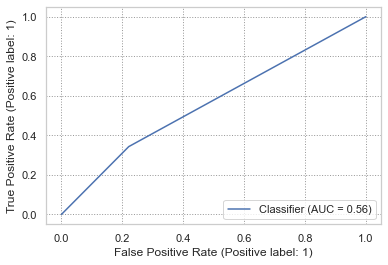

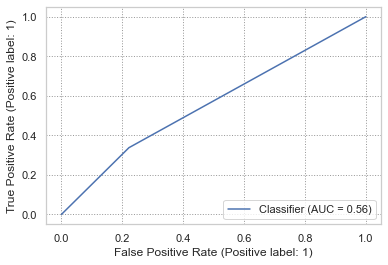

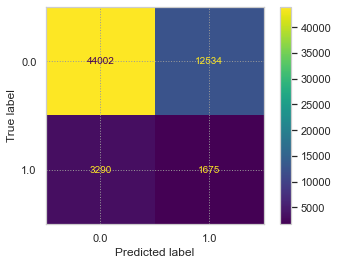

[[44002 12534]
 [ 3290  1675]]


In [ ]:
hyperoptLGBM(max_evals=20)

### Custom Metric

In [ ]:
def custom_metric(y, y_pred, **kwargs):
        cm = confusion_matrix(y, y_pred)
        tn = cm[0, 0]
        fp = cm[0, 1]
        fn = cm[1, 0]
        tp = cm[1, 1]
        
        regul = 0
        if tn+fn==0:
                regul = 1        
        # if fn==0:
        #         regul = 1                
        # n = (1-regul)/fn+regul 
        n = tn/(tn+fn+regul)

        regul = 0
        if tp+fp==0:
                regul = 1
        prec = tp/(tp+fp+regul)
        
        # return n 
        return (10*n*prec)/(9*n+prec)

custom_scorer = make_scorer(custom_metric)

In [ ]:
def MyScore(y_test, y_pred):
  return custom_metric(y_test, y_pred)

#### Baseline

Socre: 0.22811377921886739


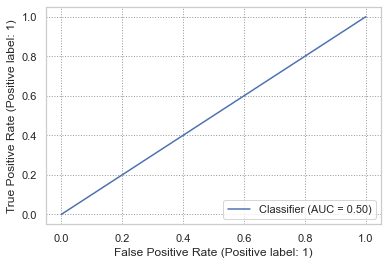

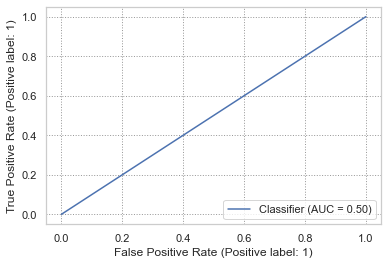

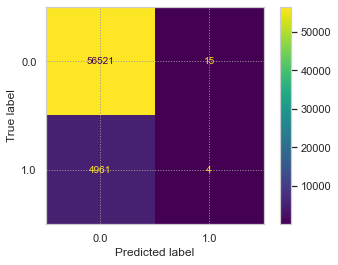

[[56521    15]
 [ 4961     4]]


In [ ]:
clf = baseline(custom_metric)
EvalDisplay(clf, custom_metric)
saveModel(clf, 'baseline_custom')

#### LGBM

In [ ]:
def roundPreds(preds, threshold=0.5):
    if threshold==None:
        threshold=0.5
    preds = (preds > threshold).astype(int)
    return preds    

In [ ]:
def lgbm_metric(y, preds, threshold=0.5):   
    preds = roundPreds(preds, threshold)
    # # eval_name, eval_result, is_higher_better
    return 'custom_metric', MyScore(y, preds), True

[LightGBM] [Info] Number of positive: 19860, number of negative: 226144
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.896600
[LightGBM] [Info] Total Bins 29802
[LightGBM] [Info] Number of data points in the train set: 246004, number of used features: 697
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 402 dense feature groups (94.78 MB) transferred to GPU in 0.054486 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432464
[LightGBM] [Info] Start training from score -2.432464
[LightGBM] [Debug] Trained a tree with leaves = 58 and depth = 9
[1]	valid_0's binary_logloss: 0.279222	valid_0's custom_metric: 0
[LightGBM] [Debug] Trained a tree with leaves = 58 

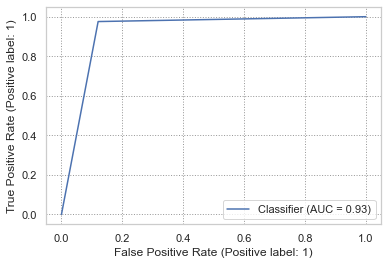

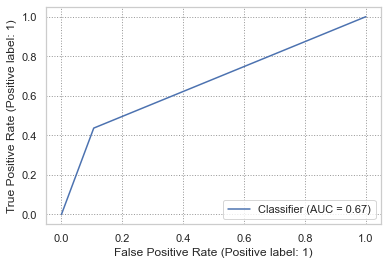

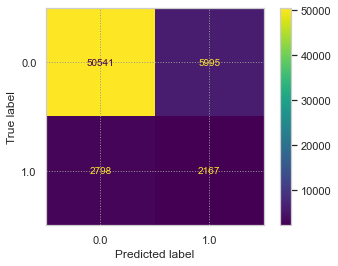

[[50541  5995]
 [ 2798  2167]]


In [ ]:
lgbmc = trainLGBM(lgbm_params, lgbm_metric, 'lgbmc')

#### LGBM Light

[LightGBM] [Info] Number of positive: 19860, number of negative: 226144
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.860232
[LightGBM] [Info] Total Bins 18359
[LightGBM] [Info] Number of data points in the train set: 246004, number of used features: 504
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 223 dense feature groups (52.55 MB) transferred to GPU in 0.035811 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080730 -> initscore=-2.432464
[LightGBM] [Info] Start training from score -2.432464
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[1]	valid_0's binary_logloss: 0.313066	valid_0's custom_metric: 0
[LightGBM] [Debug] Trained a tree with leaves = 30 a

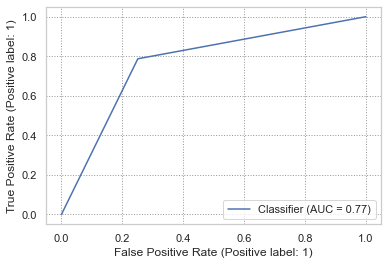

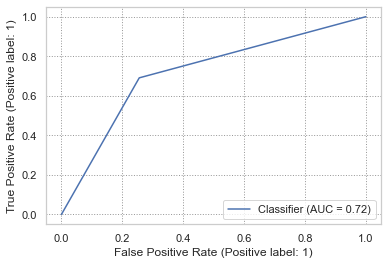

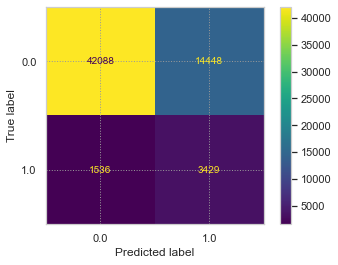

[[42088 14448]
 [ 1536  3429]]


In [ ]:
lgbm_params2 = dict(lgbm_params)
lgbm_params2['n_estimators']=100
lgbm_params2['learning_rate']=0.2
lgbm_params2['max_depth']=6
lgbm_params2['num_leaves']=30

lgbmlc = trainLGBM(lgbm_params2, lgbm_metric, 'lgbmlc')

[LightGBM] [Info] Number of positive: 179457, number of negative: 179457
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.877737
[LightGBM] [Info] Total Bins 31839
[LightGBM] [Info] Number of data points in the train set: 358914, number of used features: 508
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1080, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 64 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 236 dense feature groups (80.78 MB) transferred to GPU in 0.054989 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
Training until validation scores don't improve for 5 rounds
Using 0.001 as min_delta for all metrics.
[LightGBM] [Debug] Trained a tree with leaves = 30 and depth = 6
[Ligh

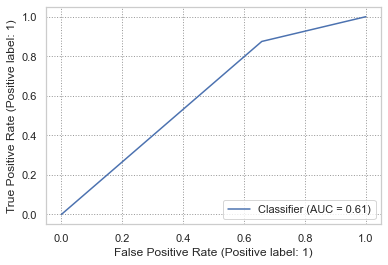

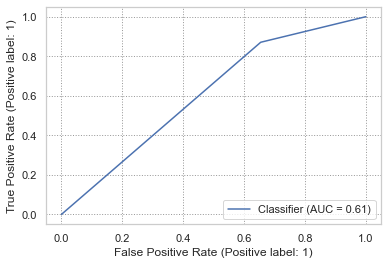

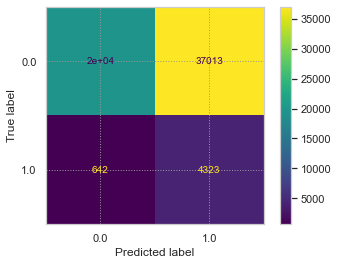

[[19523 37013]
 [  642  4323]]


In [ ]:
lgbmlc_cv = trainLGBM_CV(lgbm_params2, lgbm_metric, 'lgbmlc_cv')

#### LGBM Flaml

In [ ]:
def custom_metric_flaml(
    X_test,
    y_test,
    estimator,
    labels,
    X_train,
    y_train,
    weight_test=None,
    weight_train=None,
    config=None,
    groups_test=None,
    groups_train=None,
):
    from sklearn.metrics import log_loss
    import time

    start = time.time()
    y_pred = estimator.predict(X_test)    
    pred_time = (time.time() - start) / len(X_test)
    test_loss = custom_metric(y_test, y_pred)    
    y_pred = estimator.predict(X_train)
    train_loss = custom_metric(y_train, y_pred)
    alpha = 0.5
    return test_loss * (1 + alpha) - alpha * train_loss, {
        "test_loss": test_loss,
        "train_loss": train_loss,
        "pred_time": pred_time,
    }

[flaml.automl: 09-03 01:22:04] {2565} INFO - task = classification
[flaml.automl: 09-03 01:22:04] {2567} INFO - Data split method: stratified
[flaml.automl: 09-03 01:22:04] {2570} INFO - Evaluation method: holdout
[flaml.automl: 09-03 01:22:06] {2689} INFO - Minimizing error metric: customized metric
[flaml.automl: 09-03 01:22:06] {2831} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl: 09-03 01:22:06] {3133} INFO - iteration 0, current learner lgbm
[flaml.automl: 09-03 01:22:06] {3266} INFO - Estimated sufficient time budget=31660s. Estimated necessary time budget=32s.
[flaml.automl: 09-03 01:22:06] {3313} INFO -  at 2.2s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 09-03 01:22:06] {3133} INFO - iteration 1, current learner lgbm
[flaml.automl: 09-03 01:22:06] {3313} INFO -  at 2.4s,	estimator lgbm's best error=0.0000,	best estimator lgbm's best error=0.0000
[flaml.automl: 09-03 01:22:06] {3133} INFO - iteration 2, current 

Best hyperparmeter config: {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0, 'FLAML_sample_size': 10000}
Best accuracy on validation data: 1
Training duration of best run: 2.549 s
Socre: 0.5


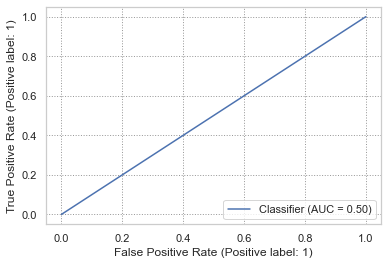

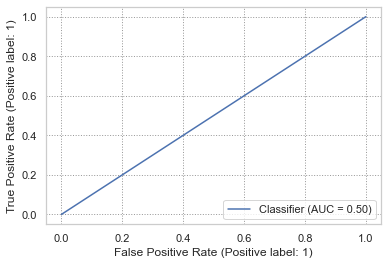

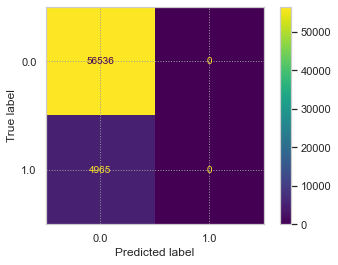

[[56536     0]
 [ 4965     0]]


In [ ]:
flamlLGBM(time=3600*2, metric=custom_metric_flaml, name='flamlgbmc')

#### LGBM & HyperOPT

Training until validation scores don't improve for 5 rounds
Using 0.001 as min_delta for all metrics.             
Early stopping, best iteration is:                    
[1]	valid_0's binary_logloss: 0.660442	valid_0's custom_metric: 0.548194
Training until validation scores don't improve for 5 rounds
Using 0.001 as min_delta for all metrics.             
Early stopping, best iteration is:                    
[1]	valid_0's binary_logloss: 0.662702	valid_0's custom_metric: 0.56944
Training until validation scores don't improve for 5 rounds
Using 0.001 as min_delta for all metrics.             
Early stopping, best iteration is:                    
[1]	valid_0's binary_logloss: 0.661856	valid_0's custom_metric: 0.578015
Training until validation scores don't improve for 5 rounds                          
Using 0.001 as min_delta for all metrics.                                            
Early stopping, best iteration is:                                                   
[2]	valid_0's 

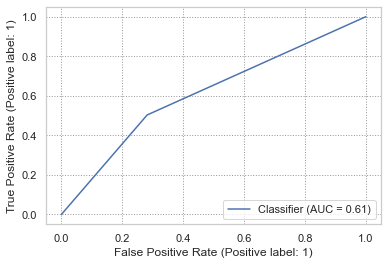

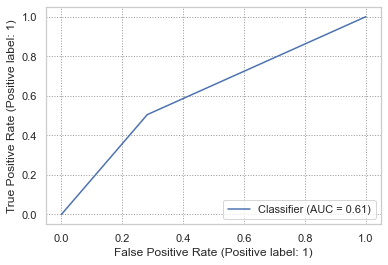

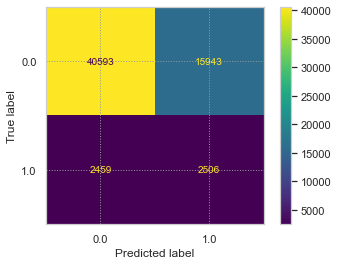

[[40593 15943]
 [ 2459  2506]]


In [ ]:
hyperoptLGBM(max_evals=20, eval_metric=custom_metric, name='lgbmhc')

[LightGBM] [Warning] colsample_bytree is set=1.0, colsample_bytree= will be ignored. Current value: colsample_bytree=1.0
[LightGBM] [Warning] Unknown parameter: 0.20586656876842746
Training until validation scores don't improve for 5 rounds
Using 0.001 as min_delta for all metrics.
Early stopping, best iteration is:
[10]	valid_0's binary_logloss: 0.562365	valid_0's custom_metric: 0.627765
[LightGBM] [Warning] colsample_bytree is set=1.0, colsample_bytree= will be ignored. Current value: colsample_bytree=1.0
[LightGBM] [Warning] Unknown parameter: 0.20586656876842746
Training until validation scores don't improve for 5 rounds
Using 0.001 as min_delta for all metrics.
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.554669	valid_0's custom_metric: 0.622364
[LightGBM] [Warning] colsample_bytree is set=1.0, colsample_bytree= will be ignored. Current value: colsample_bytree=1.0
[LightGBM] [Warning] Unknown parameter: 0.20586656876842746
Training until validation scores do

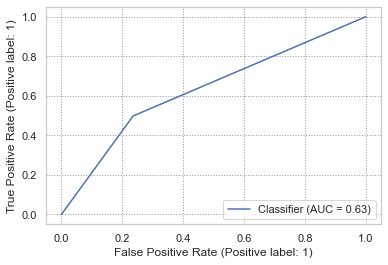

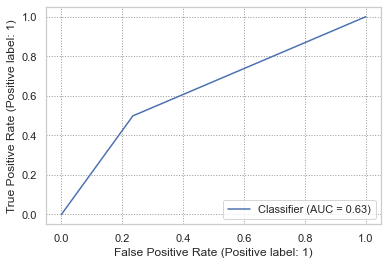

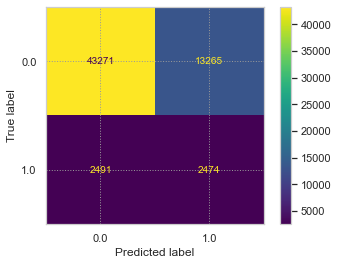

[[43271 13265]
 [ 2491  2474]]


In [ ]:
best_params3 = {'colsample_bytree ': 0.20586656876842746, 'learning_rate': 0.2367523618081393, 'max_bin': 3, 'max_depth': 8, 'min_child_samples': 97, 'min_child_weight': 2.2279723468227295, 'n_estimators': 200, 'num_leaves': 2, 'reg_alpha': 0.14498191471518698, 'reg_lambda': 1.2078436292681194, 'subsample': 0.624546691136082}
lgbmhcl = trainLGBM_CV(best_params3, lgbm_metric, 'lgbmhcl')

# 4. Interpretation du Modèle

In [ ]:
model = None
with open("model.pkl", "rb") as f:
    model = dill.load(f)

## 4.1. Description du Modèle

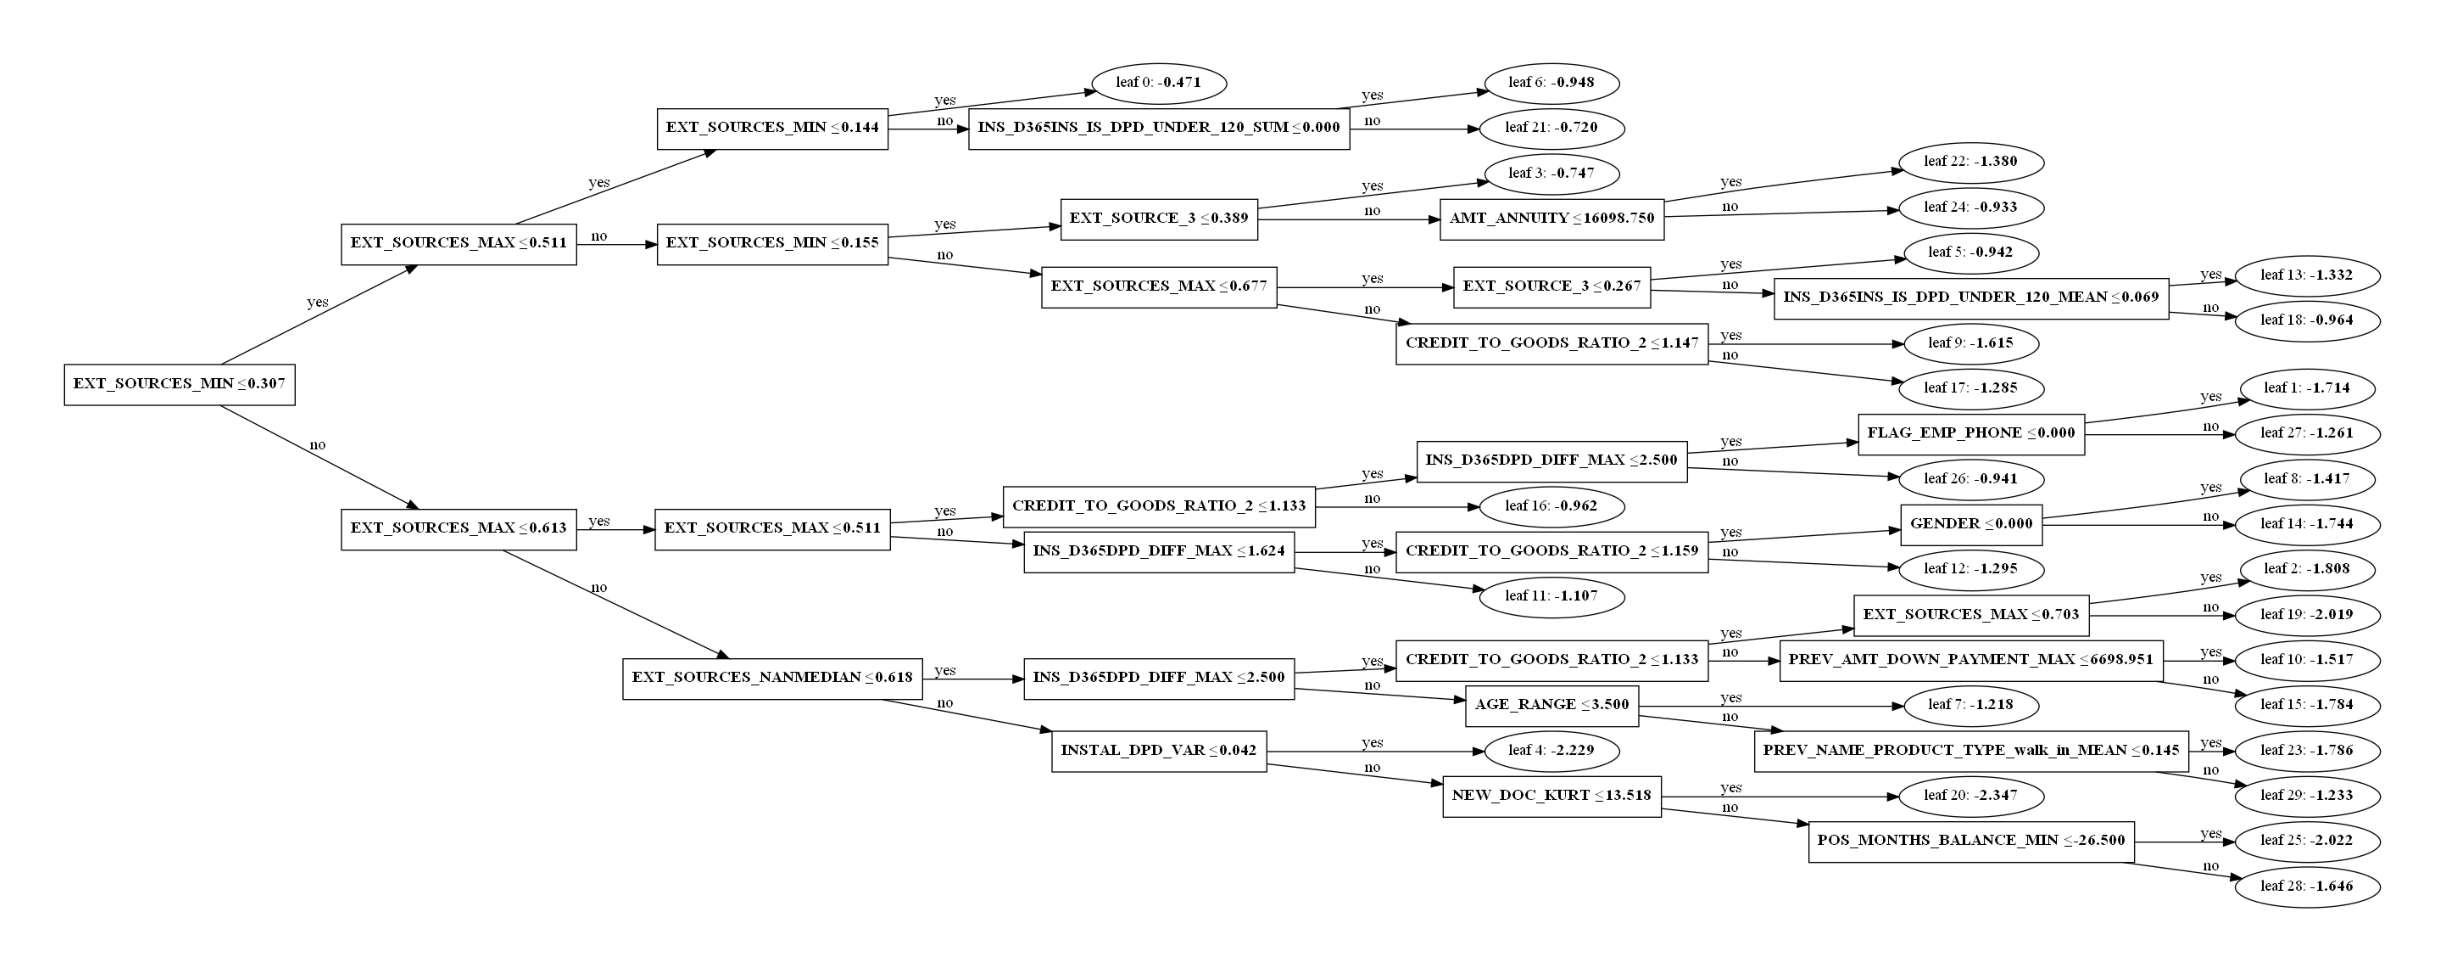

In [ ]:
_= plot_tree(model, figsize=(5,2), dpi=600)

## 4.2. Importance des features : SHAP

### 4.2.1. Au niveau Global

In [ ]:
X = x_train
explainer = shap.TreeExplainer(model, X, model_output='probability')
shap_explanations = explainer(X)
expected_value = explainer.expected_value
shap_values = explainer.shap_values(X)

100%|===================| 245864/246004 [20:42<00:00]        

In [ ]:
with open("explainer.pkl",'wb') as io:
    dill.dump(explainer,io)
with open("shap_explanations.pkl",'wb') as io:
    dill.dump(shap_explanations,io)

In [ ]:
X = x_train
explainer = None
with open("explainer.pkl", "rb") as f:
    explainer = dill.load(f)
shap_explanations = None
with open("shap_explanations.pkl", "rb") as f:
    shap_explanations = dill.load(f)
expected_value = explainer.expected_value
shap_values = explainer.shap_values(X)

100%|===================| 245945/246004 [20:33<00:00]        

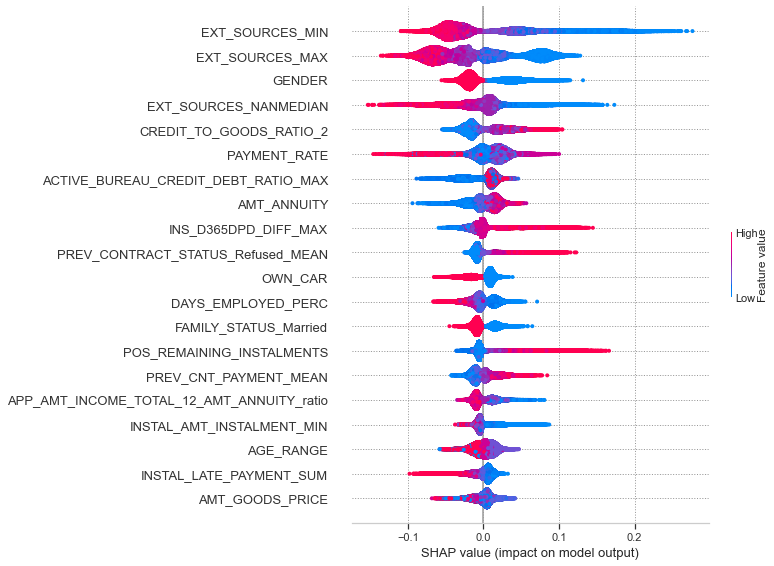

In [ ]:
shap.summary_plot(shap_values, X, max_display=20)

### 4.2.1. Au niveau Local

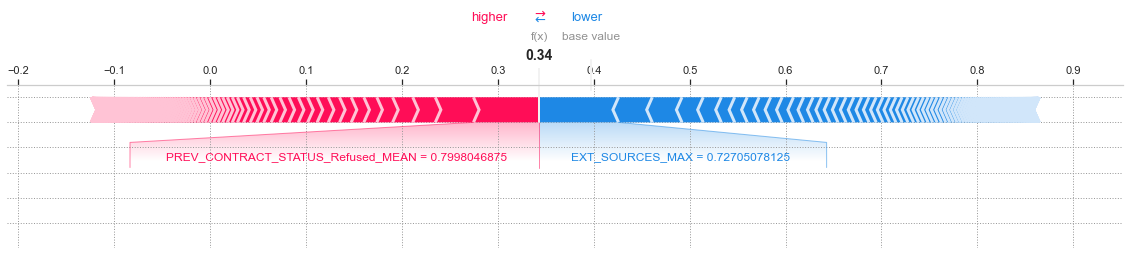

In [ ]:
shap.plots.force(expected_value, shap_values[0], X.iloc[0, :], matplotlib=True)

In [ ]:
model.predict_proba([x_train.values[1]])

array([[0.69868468, 0.30131532]])

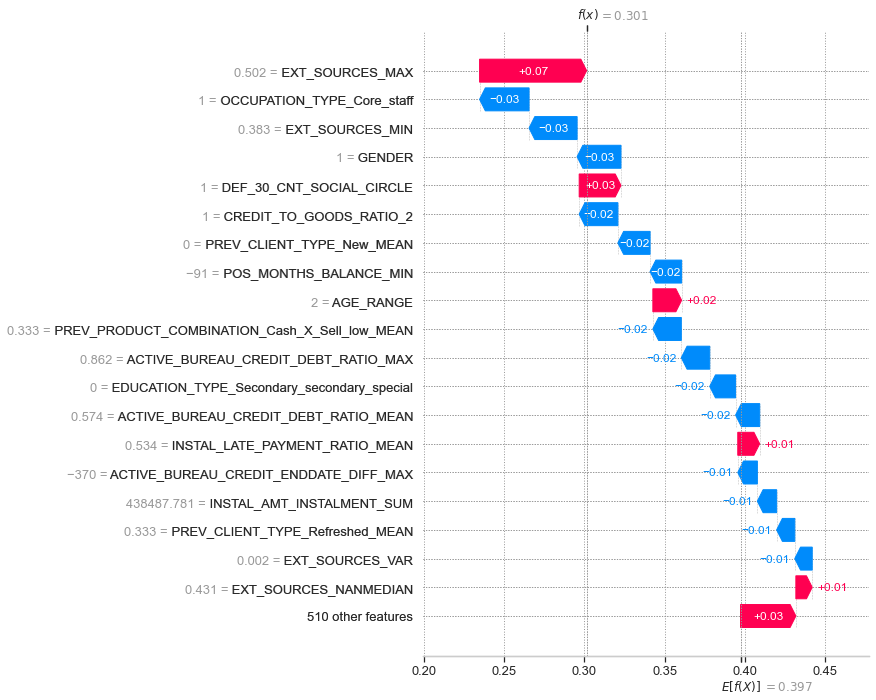

In [ ]:
shap.plots.waterfall(shap_explanations[1], max_display=20)